## Importando dependências

In [1]:
import numpy as np
import sys
import pandas as pd
from pandas import DataFrame
import tensorflow as tf
import matplotlib.pyplot as plt
import multiprocessing as mp
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.losses import Loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Binarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE

## Importando dataset e pre-processando

In [2]:
def normalize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    unique_labels = sorted(list(set(y)))
    for i in range(len(y)):
        y[i] = unique_labels.index(y[i])
    dataset.iloc[:, -1] = y
    
def binarize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    binarizer = Binarizer()
    y = binarizer.fit_transform([y])[0]
    dataset.iloc[:, -1] = y
    

HEADER = ["timestamp",'srcip', 'srcport', 'dstip', 'dstport', 'proto', 'total_fpackets', 'total_fvolume',
          'total_bpackets', 'total_bvolume', 'min_fpktl', 'mean_fpktl', 'max_fpktl', 'std_fpktl', 'min_bpktl',
          'mean_bpktl', 'max_bpktl', 'std_bpktl', 'min_fiat', 'mean_fiat', 'max_fiat', 'std_fiat', 'min_biat',
          'mean_biat', 'max_biat', 'std_biat', 'duration', 'min_active', 'mean_active', 'max_active', 'std_active',
          'min_idle', 'mean_idle', 'max_idle', 'std_idle', 'sflow_fpackets', 'sflow_fbytes', 'sflow_bpackets',
          'sflow_bbytes', 'fpsh_cnt', 'bpsh_cnt', 'furg_cnt', 'burg_cnt', 'total_fhlen', 'total_bhlen', "dscp", 'class']
initial_dataset_02_24 = pd.read_csv('dataset-oi-2017-02-24-summarized.csv', names=HEADER, header=1)
initial_dataset_02_25 = pd.read_csv('dataset-oi-2017-02-25-summarized.csv', names=HEADER, header=1)
initial_dataset_02_26 = pd.read_csv('dataset-oi-2017-02-26-summarized.csv', names=HEADER, header=1)
initial_dataset_02_27 = pd.read_csv('dataset-oi-2017-02-27-summarized.csv', names=HEADER, header=1)
initial_dataset_02_28 = pd.read_csv('dataset-oi-2017-02-28-summarized.csv', names=HEADER, header=1)

initial_dataset_02_24 = initial_dataset_02_24.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_25 = initial_dataset_02_25.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_26 = initial_dataset_02_26.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_27 = initial_dataset_02_27.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_28 = initial_dataset_02_28.replace([np.inf, -np.inf], np.nan).dropna()

initial_dataset = initial_dataset_02_24.append(initial_dataset_02_25, ignore_index=True)
initial_dataset = initial_dataset.append(initial_dataset_02_26, ignore_index=True)
initial_dataset = initial_dataset.append(initial_dataset_02_27, ignore_index=True)
initial_dataset = initial_dataset.append(initial_dataset_02_28, ignore_index=True)

binarize_dataset_labels(initial_dataset)

/root/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Criando modelo do nó

In [14]:
class Node:
    def __init__(self, node_id = 123, dataset = DataFrame(list())):
        self.node_id = node_id
        self.local_dataset = dataset
        self.local_decision_tree = DecisionTreeClassifier(max_depth=10, criterion='entropy')
        self.local_forest = [self.local_decision_tree]
        self.metrics_history = [0 for _ in range(8)]
        
    def apply_oversample(self, X, y):
        labels_counts = self.local_dataset['class'].value_counts()
        target_label = labels_counts.keys()[1]
        max_samples = int(labels_counts.values[0] * 0.9)
        current_samples = labels_counts.values[1]
        
        if current_samples >= max_samples:
            return X, y
        
        smote_oversample = SMOTE(sampling_strategy={target_label: max_samples})
        return smote_oversample.fit_resample(X, y)

        
    def preprocess(self):
        X = self.local_dataset.iloc[:, 5:-1].values
        y = self.local_dataset.iloc[:, -1].values

        X, y = self.apply_oversample(X, y)
                
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.2)        
        
    def train_decision_tree(self):
        self.local_decision_tree.fit(self.X_train, self.y_train)
        
    def test_decision_tree(self):
        y_pred = self.local_decision_tree.predict(self.X_test)
        
        self.metrics_history[1] = precision_score(self.y_test, y_pred)
        self.metrics_history[2] = recall_score(self.y_test, y_pred)
        self.metrics_history[3] = f1_score(self.y_test, y_pred)
        
        self.metrics_history[0] = self.local_decision_tree.score(self.X_test, self.y_test)
        print(f"[INFO] Accuracy of node {self.node_id} tree = {self.metrics_history[0]}")
        
        cm = confusion_matrix(self.y_test, y_pred)
        print(cm)  

## Splitando dataset para os nós participantes

In [41]:
import random
def split_dataset_non_iid(nodes):
        unique_ips = initial_dataset['srcip'].value_counts().head(100).keys()
        ips_range = len(unique_ips)
        node_index, id_list = (0,[])
        while node_index < num_nodes:
            srcip_id = random.randint(0,ips_range-1)
            if srcip_id not in id_list:
                id_list.append(srcip_id)
                local_dataset = initial_dataset.loc[initial_dataset['srcip'] == unique_ips[srcip_id]]
                value_counts = local_dataset['class'].value_counts()
                num_classes = len(value_counts)
                if num_classes > 1:
                    print(f"Value counts for node {node_index}\n{value_counts}")
                    nodes[node_index].local_dataset = local_dataset
                    node_index += 1
        
num_nodes = 30
forest_size = 5
nodes = [Node(node_id = i) for i in range(num_nodes)]  

split_dataset_non_iid(nodes)

values counts for node 0 = 0.0    1078246
1.0     392294
Name: class, dtype: int64
values counts for node 1 = 0.0    1270399
1.0     148811
Name: class, dtype: int64
values counts for node 2 = 0.0    836686
1.0       128
Name: class, dtype: int64
values counts for node 3 = 0.0    316234
1.0     22658
Name: class, dtype: int64
values counts for node 4 = 1.0    152389
0.0    143556
Name: class, dtype: int64
values counts for node 5 = 0.0    162832
1.0    123412
Name: class, dtype: int64
values counts for node 6 = 0.0    256024
1.0      5034
Name: class, dtype: int64
values counts for node 7 = 0.0    196733
1.0     48044
Name: class, dtype: int64
values counts for node 8 = 0.0    239821
1.0       512
Name: class, dtype: int64
values counts for node 9 = 1.0    119982
0.0     91972
Name: class, dtype: int64
values counts for node 10 = 0.0    189279
1.0      1727
Name: class, dtype: int64
values counts for node 11 = 0.0    186722
1.0        79
Name: class, dtype: int64
values counts for node

In [15]:
# import random
# def split_dataset_non_iid(nodes):
#         unique_ips = initial_dataset['srcip'].value_counts().head(100).keys()
#         ips_range = len(unique_ips)
#         node_index, id_list = (0,[])
#         while node_index < num_nodes:
#             srcip_id = random.randint(0,ips_range-1)
#             if srcip_id not in id_list:
#                 id_list.append(srcip_id)
#                 local_dataset = initial_dataset.loc[initial_dataset['srcip'] == unique_ips[srcip_id]]
#                 value_counts = local_dataset['class'].value_counts()
#                 num_classes = len(value_counts)
#                 if num_classes > 1:
#                     print(f"Value counts for node {node_index}\n{value_counts}")
#                     nodes[node_index].local_dataset = local_dataset
#                     node_index += 1

        
        
# num_nodes = 30
# forest_size = 10
# nodes = [Node(node_id = i) for i in range(num_nodes)]  

# split_dataset_non_iid(nodes)

Value counts for node 0
0.0    83484
1.0    68343
Name: class, dtype: int64
Value counts for node 1
0.0    50672
1.0    17196
Name: class, dtype: int64
Value counts for node 2
0.0    62881
1.0      840
Name: class, dtype: int64
Value counts for node 3
0.0    45580
1.0       15
Name: class, dtype: int64
Value counts for node 4
0.0    47478
1.0      239
Name: class, dtype: int64
Value counts for node 5
1.0    61001
0.0    48522
Name: class, dtype: int64
Value counts for node 6
0.0    83392
1.0       82
Name: class, dtype: int64
Value counts for node 7
0.0    39867
1.0      189
Name: class, dtype: int64
Value counts for node 8
0.0    40708
1.0     1676
Name: class, dtype: int64
Value counts for node 9
0.0    54802
1.0    10107
Name: class, dtype: int64
Value counts for node 10
0.0    97560
1.0      390
Name: class, dtype: int64
Value counts for node 11
0.0    51038
1.0    33748
Name: class, dtype: int64
Value counts for node 12
0.0    111212
1.0      9173
Name: class, dtype: int64
Value c

## Treinando e testando DTs locais

In [44]:
for node in nodes:
    node.preprocess()
    node.train_decision_tree()
    node.test_decision_tree()

print("[INFO] All local trains are finished!")

[INFO] Accuracy of node 0 tree = 0.785878155095745
[[149852  65586]
 [ 22147 172149]]
[INFO] Accuracy of node 1 tree = 0.7915534270184277
[[226430  27555]
 [ 73073 155694]]
[INFO] Accuracy of node 2 tree = 0.765745845927389
[[163987   3290]
 [ 71189  79475]]
[INFO] Accuracy of node 3 tree = 0.99222761277867
[[63010   308]
 [  626 56225]]
[INFO] Accuracy of node 4 tree = 0.8153879943908496
[[22693  6049]
 [ 4878 25569]]
[INFO] Accuracy of node 5 tree = 0.781272221863081
[[21317 11347]
 [ 2187 27025]]
[INFO] Accuracy of node 6 tree = 0.9300845933250419
[[50082   979]
 [ 5823 40405]]
[INFO] Accuracy of node 7 tree = 0.912545646677992
[[32897  6452]
 [   86 35324]]
[INFO] Accuracy of node 8 tree = 0.9575341263222579
[[45241  2872]
 [  998 42021]]
[INFO] Accuracy of node 9 tree = 0.9384773978461606
[[19551  2109]
 [  696 23237]]
[INFO] Accuracy of node 10 tree = 0.9527987097850569
[[34395  3375]
 [   20 34136]]
[INFO] Accuracy of node 11 tree = 0.9922767951518568
[[36928   548]
 [    0 3347

## Compartilhando DTs e atualizando o DFs


In [ ]:
# for node in nodes:
#     node.local_forest = [node.local_decision_tree]

In [45]:
import random
forest_size = 6
for current in range(num_nodes):
    metric_list = []
    print(f"Starting sharing for node {current}")
    for neighbour in range(num_nodes):
        if current != neighbour:
            neighbour_tree = nodes[neighbour].local_decision_tree
            acc = neighbour_tree.score(nodes[current].X_test, nodes[current].y_test)
            y_pred = neighbour_tree.predict(nodes[current].X_test)
            rec = recall_score(nodes[current].y_test, y_pred)
#             prec = precision_score(nodes[current].y_test, y_pred)
            metric_score = acc
            
            if len(nodes[current].local_forest) <= forest_size:
                nodes[current].local_forest.append(neighbour_tree)
                metric_list.append(metric_score)
            else:
                min_metric = min(metric_list)
                min_index = metric_list.index(min_metric)
                if min_metric < metric_score:
                    nodes[current].local_forest[min_index] = neighbour_tree
                    metric_list[min_index] = metric_score
    print(f"{metric_list}\n")
                

Starting sharing for node 0
[0.6771954487545578, 0.7077542991306555, 0.6860328896308336, 0.6777836352365193, 0.7447539135146217, 0.743321276730757]

Starting sharing for node 1
[0.6966848402492377, 0.6548310519687127, 0.7254242343895002, 0.6464209366299881, 0.7133517831101683, 0.6411511500729152]

Starting sharing for node 2
[0.6153468725329543, 0.6252386449058158, 0.6507937007180578, 0.6151361416111795, 0.632170748660915, 0.6248895235279501]

Starting sharing for node 3
[0.7335752149056745, 0.5692732734731919, 0.5564413451056429, 0.5625327663540514, 0.6427031930031871, 0.5475954697134868]

Starting sharing for node 4
[0.7849600432512798, 0.801280643362787, 0.7049113855615063, 0.7967696700400412, 0.7924276470290088, 0.8034432073527176]

Starting sharing for node 5
[0.7730622535393368, 0.718873230331631, 0.7611513349279203, 0.7407395436033357, 0.7234307324326071, 0.7394789579158316]

Starting sharing for node 6
[0.7241517540523594, 0.7849808303096959, 0.7273175795824811, 0.7423758081591

## Testando a floresta de decisão dos nós

In [46]:
from statistics import mode
def forest_predict(forest, X):
    forest_prediction = list()
    tree_predictions = list()
    for tree in forest:
        tree_predictions.append(tree.predict(X))
    for row_index in range(X.shape[0]):
        row_predictions = list()
        for tree_index in range(forest_size):
            row_predictions.append(tree_predictions[tree_index][row_index])
        forest_prediction.append(mode(row_predictions))
    return forest_prediction

for node in nodes:
    accuracy = Accuracy()
    forest_pred = forest_predict(node.local_forest, node.X_test)
    accuracy.update_state(node.y_test, forest_pred)
    node.metrics_history[4] = accuracy.result().numpy()
    node.metrics_history[5] = precision_score(node.y_test, forest_pred, zero_division=0)
    node.metrics_history[6] = recall_score(node.y_test, forest_pred)
    node.metrics_history[7] = f1_score(node.y_test, forest_pred)

    print(f"[INFO] Accuracy of node {node.node_id} forest = {node.metrics_history[4]}")

[INFO] Accuracy of node 0 forest = 0.755556046962738
[INFO] Accuracy of node 1 forest = 0.705975353717804
[INFO] Accuracy of node 2 forest = 0.6080467700958252
[INFO] Accuracy of node 3 forest = 0.526009202003479
[INFO] Accuracy of node 4 forest = 0.8101842999458313
[INFO] Accuracy of node 5 forest = 0.7748238444328308
[INFO] Accuracy of node 6 forest = 0.7714232802391052
[INFO] Accuracy of node 7 forest = 0.5302639007568359
[INFO] Accuracy of node 8 forest = 0.7295241951942444
[INFO] Accuracy of node 9 forest = 0.9365034103393555
[INFO] Accuracy of node 10 forest = 0.8920557498931885
[INFO] Accuracy of node 11 forest = 0.7831724286079407
[INFO] Accuracy of node 12 forest = 0.713945209980011
[INFO] Accuracy of node 13 forest = 0.6124051809310913
[INFO] Accuracy of node 14 forest = 0.8019804954528809
[INFO] Accuracy of node 15 forest = 0.7997730374336243
[INFO] Accuracy of node 16 forest = 0.7729770541191101
[INFO] Accuracy of node 17 forest = 0.8859991431236267
[INFO] Accuracy of node 

## Plotando resultados dos treinos locais

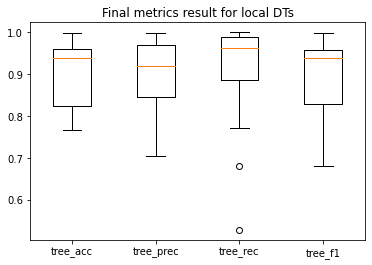

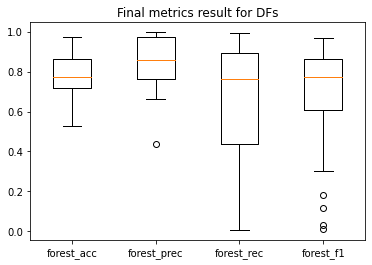

In [47]:
final_metrics = [[], [], [], [], [], [], [], []]
for node in nodes:
    for i in range(8):
        final_metrics[i].append(node.metrics_history[i])

# Boxplot das árvores de decisão
plt.boxplot(final_metrics[:4])
plt.title('Final metrics result for local DTs')
plt.xticks([1, 2, 3, 4], ['tree_acc', 'tree_prec', 'tree_rec', 'tree_f1'])
plt.show()

# Boxplot das florestas de decisão
plt.boxplot(final_metrics[4:])
plt.title('Final metrics result for DFs')
plt.xticks([1, 2, 3, 4], ['forest_acc', 'forest_prec', 'forest_rec', 'forest_f1'])
plt.show()